# GEOG 5160 6160 Lab 09

Let's begin by importing the packages we'll need for the lab:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
## Set random seed for reproducibility
np.random.seed(1234)

## Regression neural networks

We'll start with an example of using a neural network for a regression task. The data are taken from a Kaggle competition and are based on a set of 77 breakfast cereals. A description of the data is given in the appendix. The last field in the file (`rating`) is the outcome variable that we will build the network for. Start by reading the file:

In [2]:
cereal = pd.read_csv("../datafiles/cereals.csv")
print(cereal.shape)

(77, 16)


In [3]:
cereal.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25.0,3,1.0,0.33,68.40
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0.0,3,1.0,1.00,33.98
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25.0,3,1.0,0.33,59.43
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25.0,3,1.0,0.50,93.70
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25.0,3,1.0,0.75,34.38


Next, we'll select a subset of the numeric features for modeling, as well as the outcome variable. We can use this to plot a correlation matrix showing the correlation between each variable (including the outcome `rating`)

In [4]:
cereal = cereal[['rating','calories','protein','fat','sodium','fiber']]

<AxesSubplot:>

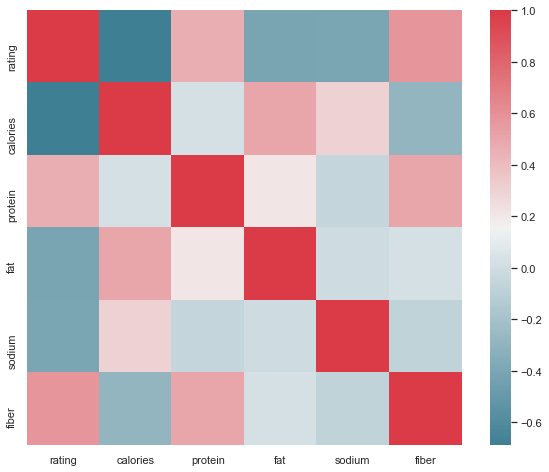

In [5]:
f, ax = plt.subplots(figsize=(10, 8))
corr = cereal.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Linear model

We'll start by making a linear model as a baseline for comparisons with the neural network. First, we'll make up the set of features and labels, and then split these into two for simple hold-out based cross-validation

In [6]:
from sklearn.model_selection import train_test_split

X = cereal[['calories','protein','fat','sodium','fiber']]
y = cereal['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8)

In [7]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
print(lin_reg.score(X_train, y_train))

0.8243665905258365


This is a reasonable model with an R$^2$ of about 0.81. Now, we can test it's predictive skill by calculating the root mean squared error (RMSE)

In [8]:
y_test_pred = lin_reg.predict(X_test)
from sklearn.metrics import mean_squared_error
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 5.29


In [25]:
from sklearn.model_selection import cross_val_score, KFold
# define model evaluation method
cv = KFold(n_splits=5)

scores = cross_val_score(lin_reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')
print("%.3f" % np.mean(-scores))

6.473


### Neural network

Now we'll turn to making a neural network. We'll again use scikit-learn to build the network. As the network uses weighted sums of the input features, it's important that none of these are on very different scales. The easiest way to avoid this is to scale all variables to approximately the same range. The scaling we use here is a min-max transformation or *normalization* (i.e. each variable is converted to a 0-1 range). This transformation is given by the following equation. 

$x_i'=\frac{x_i-min(x)}{max(x)-min(x)}$

To calculate this, we'll take advantage of some Pandas functions here that calculate the minimum and maximum of each column:  

In [9]:
X_normalized = (X - X.min()) / (X.max() - X.min())

To check this has worked, let's look at the min and max values for each column in the new DataFrame:

In [10]:
print(X_normalized.min())
print(X_normalized.max())

calories    0.0
protein     0.0
fat         0.0
sodium      0.0
fiber       0.0
dtype: float64
calories    1.0
protein     1.0
fat         1.0
sodium      1.0
fiber       1.0
dtype: float64


Now let's re-create our training and testing set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y,
                                                    train_size = 0.8)

We can now fit the network. A few arguments to note:

- `hidden_layer_sizes`: this defines the size (and number) of hidden layers. 
- `activation`: The activation function. For this first attempt, we'll use a linear function (`identity`)
- `solver`: the optimization method. We'll use `lbfgs` here, as it works well with small datasets. An alternative for larger data is `adam`. 

In [12]:
from sklearn.neural_network import MLPRegressor

In [13]:
nn_reg = MLPRegressor(hidden_layer_sizes=(3,),  
                      activation='logistic', 
                      solver='lbfgs', 
                      max_iter = 200)

In [14]:
nn_reg.fit(X_train, y_train)
print(nn_reg.score(X_test, y_test))
nn_reg.n_iter_

0.2641212150727995


/opt/miniconda3/envs/geog5160/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


200

In [15]:
y_test_pred = nn_reg.predict(X_test)
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 11.42


In [16]:
nn_reg = MLPRegressor(hidden_layer_sizes=(3,),  
                      activation='logistic', 
                      solver='lbfgs', 
                      max_iter = 500,
                     random_state = 1)
nn_reg.fit(X_train, y_train)
y_test_pred = nn_reg.predict(X_test)
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 10.67


In [17]:
import VisualizeNN as VisNN
#network_structure = np.hstack(([X_train.shape[1]], 
#                               np.asarray(nn_reg.hidden_layer_sizes), 
#                               [y_train.shape[1]]))
network_structure = np.hstack(([X_train.shape[1]], 
                               np.asarray(nn_reg.hidden_layer_sizes), 
                               [1]))

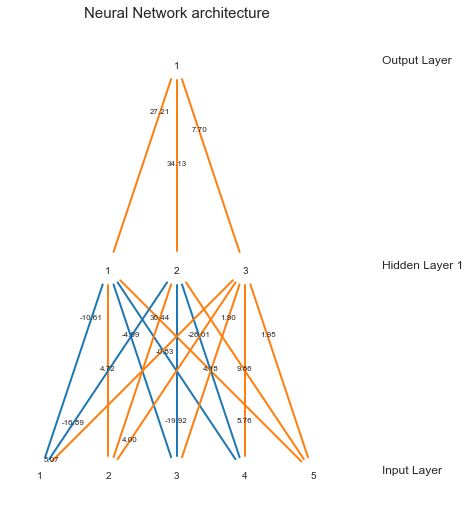

In [18]:
network=VisNN.DrawNN(network_structure, nn_reg.coefs_)
network.draw()

In [19]:
X_train.shape[1]
#y_train.shape[1]

5

The key parameter in a multi-layer neural network is the definition of the hidden layers, which include

- the number of layers
- the number of nodes in each layer

A good rule of thumb for the number of nodes is that this should be somewhere between the number of input and number of output nodes. However, picking this number is not straightforward. Another good suggestion is that you should generally prefer a smaller number of nodes, but a larger number of layers. 

We'll now see if adding a second hidden layer will improve the model. To do this, we simply add another value to the `hidden_layer_sizes` argument. Each value in this vector defines how many nodes to include in that layer. Here, we use two hidden layers, with 6 and 3 nodes respectively:

In [27]:
nn_reg = MLPRegressor(hidden_layer_sizes=(6,3),  
                      activation='logistic', 
                      solver='lbfgs', 
                      max_iter = 1000,
                     random_state = 1)
nn_reg.fit(X_train, y_train)
y_test_pred = nn_reg.predict(X_test)
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 9.29


/opt/miniconda3/envs/geog5160/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [28]:
nn_reg = MLPRegressor(hidden_layer_sizes=(100,),
                      activation='relu',
                      solver='sgd', 
                      max_iter=10000, 
                      random_state=1, 
                      learning_rate_init=0.01,
                      momentum = 0.6)
nn_reg.fit(X_train, y_train)
y_test_pred = nn_reg.predict(X_test)
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 5.89


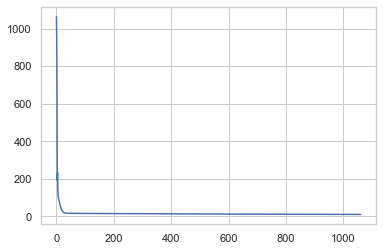

In [29]:
plt.plot(nn_reg.loss_curve_)
plt.show()

In [30]:
from sklearn.model_selection import cross_val_score, KFold
# define model evaluation method
cv = KFold(n_splits=5)

scores = cross_val_score(nn_reg, X_normalized, y, cv=cv, scoring = 'neg_root_mean_squared_error')

In [31]:
with np.printoptions(precision=3, suppress=True):
    print(scores)
print("%.3f" % np.mean(-scores))

[-6.07  -6.562 -5.411 -6.284 -7.608]
6.387


## Classification neural networks

Next, we'll build a neural network for a classification task. We'll use a new dataset, containing credit rankings for over 4000 people (see appendix for a description of the fields). The goal will be to predict `Status`, a binary outcome with two levels: `good` and `bad`. We'll start again by reading the data:

In [32]:
credit = pd.read_csv("../datafiles/credit_data.csv")
print(credit.shape)

(4454, 14)


If we take a look at the first few rows of the data, you should see that there are a mixture of numerical and categorical variables, as well as a range of different scales for the numerical variables. 

In [36]:
credit.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,good,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910


In addition, if you run the `isna()` method, you'll see that there are missing values in several of the features. As machine learning algorithms can't use missing data to train, we need to decide what to do with these missing values. 

In [38]:
credit.isna().any()

Status       False
Seniority    False
Home          True
Time         False
Age          False
Marital       True
Records      False
Job           True
Expenses     False
Income        True
Assets        True
Debt          True
Amount       False
Price        False
dtype: bool

There are several steps that we might want to do to process these data:

- Impute any missing values
- Convert categorical/factor variables to numeric by one-hot encoding
- Scale the numerical variables to prevent biases while training our neural networks

While it is possible to do this in an ad-hoc way (as we did in the previous example), we will set up a processing *pipeline* that contains all of these steps. This takes more time to set up, but has a number of advantages: we can use the pipeline directly in cross-validation or tuning, and we can use it to process any new data that we might to make predictions for, without having to remember the individual steps. The main function is `PipeOps` or `po()` which creates a pipeline operator that will carry our a single data processing step. To see the set of options, simply type:

## Exercise (NEEDS EDITING)

For the exercise we will once again use the data from the *Sonar.csv* file to model types of object (rocks 'R' or mines 'M') using the values of a set of frequency bands. The goal of the exercise is to build the best predictive neural network for predicting these data. You should use the **scikit-learn** framework to setup, train and test your model. You will need to choose a cross-validation strategy and calculate the AUC to assess the model. 

As the data has a large number of features, you should build a pipeline to reduce the number of features using one of the two filter examples from the lab (note that there are no categorical features so you can skip those steps). You should then tune both the filter and the size of the hidden layer in the network.

Your answer should consist of the following

- A description of your pipeline (this can include a figure showing the steps)
- The values you obtained for the number of features and the size of the hidden layer through tuning
- The cross-validated AUC

You should also provide your full Python code, either as a notebook or a screenshot 

## Appendix

### Cereal data set

From https://www.kaggle.com/crawford/80-cereals

|    | Column name | Feature                | 
|----|-------------|------------------------|
| 1  | `Name`      | Name of cereal          |
| 2  | `mfr`       | Manufacturer of cereal  |
|    |             | A = American Home Food Products |
|    |             | G = General Mills |
|    |             | K = Kelloggs |
|    |             | N = Nabisco |
|    |             | P = Post |
|    |             | Q = Quaker Oats |
|    |             | R = Ralston Purina |
| 3  | `type`      | cold or hot |
| 4  | `calories`  | calories per serving |
| 5  | `protein`   | grams of protein          |
| 6  | `fat`       | grams of fat         |
| 7  | `sodium`    | milligrams of sodium   |
| 8  | `fiber`     | grams of dietary fiber           |
| 9  | `carbo`     | grams of complex carbohydrates   |
| 10 | `sugars`    | grams of sugars       |
| 11 | `potass`    | milligrams of potassium       |
| 12 | `vitamins`  | vitamins and minerals - 0, 25, or 100,          |
|    |             | indicating the typical percentage of FDA recommended         |
| 13 | `shelf`     | display shelf (1, 2, or 3, counting from the floor) |
| 14 | `weight`    | weight in ounces of one serving         |
| 15 | `cups`      | number of cups in one serving          |
| 16 | `rating`    | a rating of the cereals          |

### Credit data set 

From https://github.com/gastonstat/CreditScoring

|    | Column name | Feature                | 
|----|-------------|------------------------|
| 1  | `Status`    | credit status          |
| 2  | `Seniority` | job seniority (years)  |
| 3  | `Home`      | type of home ownership |
| 4  | `Time`      | time of requested loan |
| 5  | `Age`       | client's age           |
| 6  | `Marital`   | marital status         |
| 7  | `Records`   | existence of records   |
| 8  | `Job`       | type of job            |
| 9  | `Expenses`  | amount of expenses     |
| 10 | `Income`    | amount of income       |
| 11 | `Assets`    | amount of assets       |
| 12 | `Debt`      | amount of debt         |
| 13 | `Amount`    | loan amount requested  |
| 14 | `Price`     | price of good          |

